### ANN Training Notebook for Combustion Reaction Rate Models

Jupyter notebook for training an Artificial Neural Network (ANN) to model combustion reaction rates based on seven provided values. The notebook guides you through importing necessary libraries, loading and preparing data, and training the ANN model.



### Review 
The notebook is designed to:
* Import Required Libraries: Load libraries necessary for data manipulation, machine learning, and deep learning.
* Load and Prepare Data: Process and prepare the provided data for training the ANN model.
* Train the ANN Model: Utilize TensorFlow and Keras to build and train the ANN specifically for combustion reaction rate models.
* Evaluate Model Performance: Assess the performance of the trained model to ensure its accuracy and reliability.

### Step 1: Import Required Libraries

In [16]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
#import progressbar
import multiprocessing
from functools import partial
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
#import swifter # Parallel apply function dataFrame
#from pandarallel import pandarallel # parallel package for pandas: faster for non-vectorized function
from sklearn.cluster import DBSCAN


In [17]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 
from sklearn.model_selection import train_test_split

In [18]:
file='/home/campus.ncl.ac.uk/nll93/Documents/ML_combustion_LLY/DNS_taining_data/Vflame_isothermal_training/'

### Step 2: Load and Prepare Your Data
* loop 126 to 22 snapshots

In [19]:
import h5py

# '360' and '4000' are the dimensions of y-axis and x-axis data, respectively.
# Initialize arrays to store the data. The first dimension is 75, for the 75 files.
# You may need to adjust the shape depending on the actual data structure.

nx=4000
ny=360
nt= 100 
rho_array = np.empty((nt, ny, nx))
cf_array = np.empty((nt, ny, nx))
tf_array = np.empty((nt, ny, nx))
c_var_array = np.empty((nt, ny, nx))
t_var_array = np.empty((nt, ny, nx))
SDR_c_array = np.empty((nt, ny, nx))
SDR_t_array = np.empty((nt, ny, nx))
reac_array = np.empty((nt, ny, nx))

base_path = '/home/campus.ncl.ac.uk/nll93/Documents/ML_combustion_LLY/DNS_taining_data/Vflame_isothermal_training/'
file_prefix = 'turbstats'
file_suffix = '.h5'


first_file_path = f"{base_path}{file_prefix}0126{file_suffix}"
with h5py.File(first_file_path, 'r') as f:
    x_axis = f['/Grid/x-grid'][:]
    y_axis = f['/Grid/y-grid'][:]

# Loop through file numbers
for i in range(126, 226):  # 201 because the range function is exclusive at the end
    file_number = str(i).zfill(4)  # Ensure the file number is 4 digits
    file_path = f"{base_path}{file_prefix}{file_number}{file_suffix}"
    
    try:
        with h5py.File(file_path, 'r') as f:
            # index i-126 to place each file's data in the correct slot
            idx = i - 126
            
            # the data can be directly stored into the allocated arrays
            rho_array[idx, :, :] = f['/Field/d'][:]
            cf_array[idx, :, :] = f['/Field/cf'][:]
            tf_array[idx, :, :] = f['/Field/tf'][:]
            c_var_array[idx, :, :] = f['/Field/cpcp'][:]
            t_var_array[idx, :, :] = f['/Field/tptp'][:]
            SDR_c_array[idx, :, :] = f['/Field/SDR_c'][:]
            SDR_t_array[idx, :, :] = f['/Field/SDR_t'][:]
            reac_array[idx, :, :] = f['/Field/reac'][:]
    except OSError as e:
        print(f"Error opening file {file_path}: {e}")

In [24]:
rho_array.shape

(100, 360, 4000)

In [20]:
variables_list = [rho_array, cf_array, tf_array, c_var_array, t_var_array, SDR_c_array, SDR_t_array,reac_array]

In [21]:
variables_name_list = ['rho', 'cf', 'tf', 'c_var', 't_var', 'SDR_c', 'SDR_t','reac']

In [25]:

# `variables_list` contains the 8 variables, each shaped [100, 360, 4000]

# Sizes for each set
train_size, dev_size, test_size = 75, 15, 10

# Function to reshape data for a set and stack it into the desired shape
def prepare_data_for_set(variables_list, start, end):
    # Reshape each variable's subset for the set and stack them vertically
    return np.vstack([variable[start:end, :, 800:4000].reshape(1, -1) for variable in variables_list])

# Prepare the train, dev, and test data
train_data = prepare_data_for_set(variables_list, 0, train_size)
dev_data = prepare_data_for_set(variables_list, train_size, train_size + dev_size)
test_data = prepare_data_for_set(variables_list, train_size + dev_size, train_size + dev_size + test_size)

# Verify the shapes
print(f"Train data shape: {train_data.shape}")  # Expected to be (8, 75*360*4000)
print(f"Dev data shape: {dev_data.shape}")     # Expected to be (8, 15*360*4000)
print(f"Test data shape: {test_data.shape}")   # Expected to be (8, 10*360*4000)


Train data shape: (8, 86400000)
Dev data shape: (8, 17280000)
Test data shape: (8, 11520000)


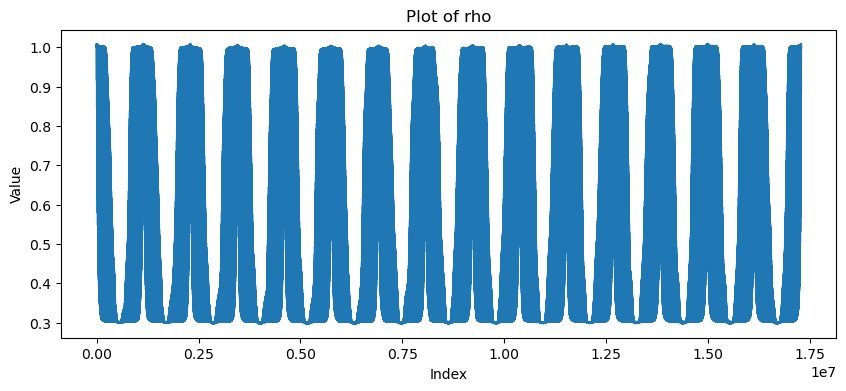

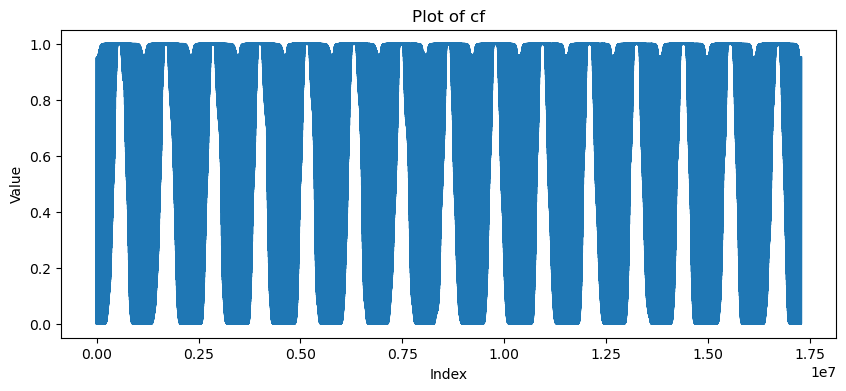

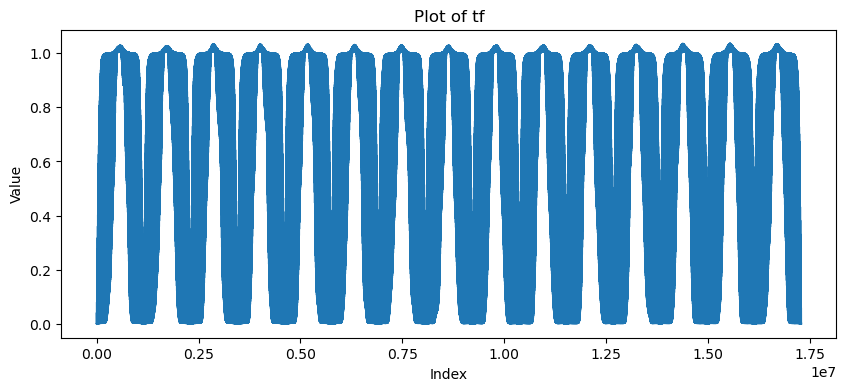

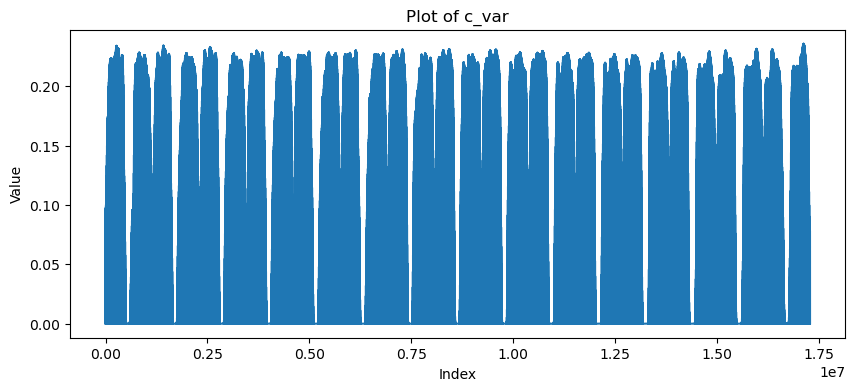

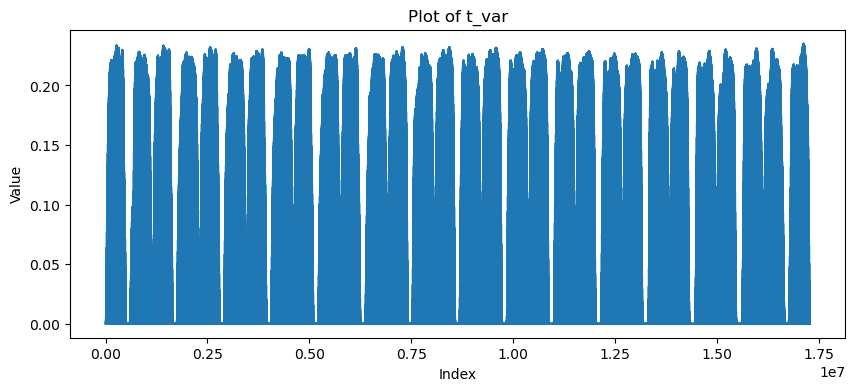

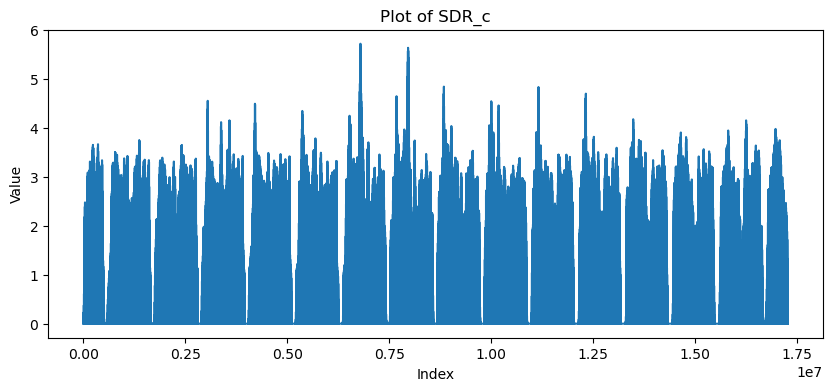

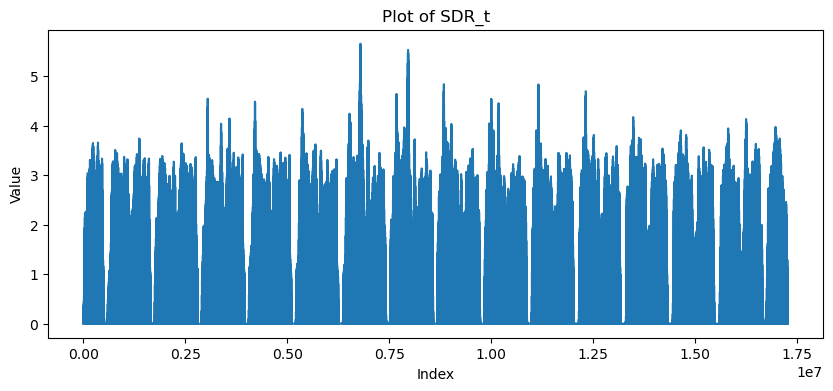

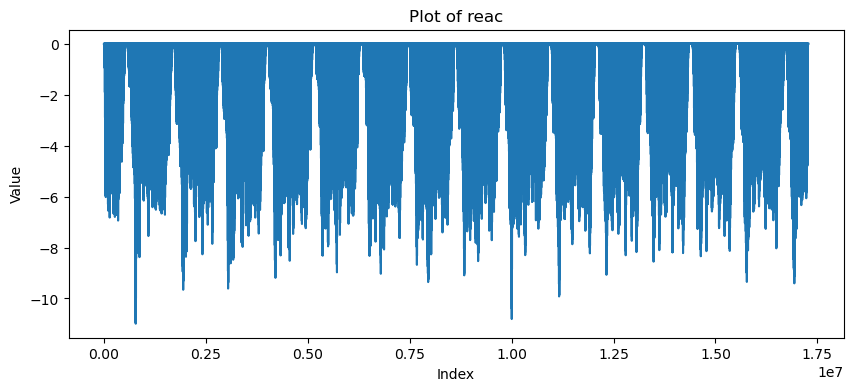

In [26]:
import matplotlib.pyplot as plt


# Here, dev_data.shape is (8, N) where N is the product of the other dimensions

variables_name_list = ['rho', 'cf', 'tf', 'c_var', 't_var', 'SDR_c', 'SDR_t', 'reac']

# Ensure this matches the shape and content of dev_data
# For demonstration, using a placeholder for dev_data
# dev_data = np.random.rand(8, 100)  # Example, replace with your actual dev_data

for i in range(8):
    plt.figure(figsize=(10, 4))  # Set the figure size for better visibility
    plt.plot(dev_data[i, :])
    plt.title(f'Plot of {variables_name_list[i]}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()



In [27]:
rho_array.shape

(100, 360, 4000)

In [28]:
x_axis.shape

(4000,)

In [29]:
y_axis.shape

(360,)

In [30]:
x_axis = np.reshape(x_axis,(len(x_axis),-1))
y_axis = np.reshape(y_axis,(len(y_axis),-1))


### import the output data

In [31]:
#  train_data is shaped as (7, 75*360*4000) for demonstration
# Where 7 represents the number of variables

# Placeholder for your reshaped arrays
# This should be replaced with actual reshaped arrays for the train set
table_train_data = {
    'rho': train_data[0,:],  # Placeholder variable
    'cf': train_data[1,:],
    'tf': train_data[2,:],
    'c_var': train_data[3,:],
    't_var': train_data[4,:],
    'SDR_c': train_data[5,:],
    'SDR_t': train_data[6,:],
    'reac': train_data[7,:]  # Assuming 'reac_reshaped' follows the same reshaping logic
}

# Convert the dictionary into a DataFrame
df_train = pd.DataFrame(table_train_data)

print(df_train.head)

<bound method NDFrame.head of                rho        cf            tf         c_var         t_var  \
0         1.003736  0.000012 -9.557033e-08  1.163751e-12  6.904468e-15   
1         1.003735  0.000012 -9.586006e-08  1.161924e-12  6.828750e-15   
2         1.003733  0.000012 -9.616322e-08  1.160105e-12  6.751437e-15   
3         1.003732  0.000012 -9.647695e-08  1.158294e-12  6.673034e-15   
4         1.003730  0.000012 -9.680097e-08  1.156491e-12  6.593835e-15   
...            ...       ...           ...           ...           ...   
86399995  0.999561  0.952035  9.054567e-08  8.028861e-05  1.743342e-14   
86399996  0.999562  0.952057  8.987507e-08  7.996130e-05  1.728693e-14   
86399997  0.999564  0.952079  8.919935e-08  7.963483e-05  1.713044e-14   
86399998  0.999565  0.952101  8.848015e-08  7.930931e-05  1.697702e-14   
86399999  0.999566  0.952124  8.777485e-08  7.898489e-05  1.681658e-14   

                 SDR_c     SDR_t          reac  
0         1.017157e-12  0.000001

In [32]:
# Similarly, you would create DataFrames for the development sets using their respective reshaped data.

#  train_data is shaped as (7, 75*360*4000) for demonstration
# Where 7 represents the number of variables

# Placeholder for your reshaped arrays
# This should be replaced with actual reshaped arrays for the train set
table_dev_data = {
    'rho': dev_data[0,:],  # Placeholder variable
    'cf': dev_data[1,:],
    'tf': dev_data[2,:],
    'c_var': dev_data[3,:],
    't_var': dev_data[4,:],
    'SDR_c': dev_data[5,:],
    'SDR_t': dev_data[6,:],
    'reac': dev_data[7,:]  # Assuming 'reac_reshaped' follows the same reshaping logic
}

# Convert the dictionary into a DataFrame
df_dev = pd.DataFrame(table_dev_data)
print(df_dev.head)

<bound method NDFrame.head of                rho        cf            tf         c_var         t_var  \
0         1.008669  0.000012 -3.578412e-07  1.223791e-12  5.520929e-14   
1         1.008670  0.000012 -3.585970e-07  1.224190e-12  5.561239e-14   
2         1.008671  0.000012 -3.593517e-07  1.224588e-12  5.601237e-14   
3         1.008672  0.000012 -3.601092e-07  1.224986e-12  5.640753e-14   
4         1.008673  0.000012 -3.608667e-07  1.225382e-12  5.679607e-14   
...            ...       ...           ...           ...           ...   
17279995  0.998900  0.950642 -6.855617e-08  3.253758e-04  9.392622e-15   
17279996  0.998900  0.950760 -6.915053e-08  3.219878e-04  9.392214e-15   
17279997  0.998901  0.950878 -6.978803e-08  3.186300e-04  9.391456e-15   
17279998  0.998901  0.950996 -7.047441e-08  3.152998e-04  9.378489e-15   
17279999  0.998902  0.951113 -7.117729e-08  3.119934e-04  9.359581e-15   

                 SDR_c     SDR_t          reac  
0         9.972853e-13  0.000004

In [33]:
# Similarly, you would create DataFrames for the test sets using their respective reshaped data.

#  train_data is shaped as (7, 75*360*4000) for demonstration
# Where 7 represents the number of variables

# Placeholder for your reshaped arrays
# This should be replaced with actual reshaped arrays for the train set
table_test_data = {
    'rho': test_data[0,:],  # Placeholder variable
    'cf': test_data[1,:],
    'tf': test_data[2,:],
    'c_var': test_data[3,:],
    't_var': test_data[4,:],
    'SDR_c': test_data[5,:],
    'SDR_t': test_data[6,:],
    'reac': test_data[7,:]  # Assuming 'reac_reshaped' follows the same reshaping logic
}

# Convert the dictionary into a DataFrame
df_test = pd.DataFrame(table_test_data)
print(df_test.head)

<bound method NDFrame.head of                rho        cf            tf         c_var         t_var  \
0         1.005167  0.000012  4.227819e-07  1.380232e-12  1.930144e-13   
1         1.005156  0.000012  4.228414e-07  1.378222e-12  1.908665e-13   
2         1.005145  0.000012  4.229075e-07  1.376213e-12  1.889026e-13   
3         1.005135  0.000012  4.229811e-07  1.374206e-12  1.871230e-13   
4         1.005124  0.000012  4.230575e-07  1.372201e-12  1.855163e-13   
...            ...       ...           ...           ...           ...   
11519995  0.999480  0.943285  4.485328e-08  3.886041e-04  3.821161e-15   
11519996  0.999479  0.943403  4.569764e-08  3.863915e-04  3.795295e-15   
11519997  0.999479  0.943521  4.652729e-08  3.841897e-04  3.773596e-15   
11519998  0.999479  0.943638  4.730965e-08  3.819986e-04  3.758636e-15   
11519999  0.999478  0.943756  4.801365e-08  3.798180e-04  3.747493e-15   

                 SDR_c         SDR_t          reac  
0         8.213868e-13  8.65

In [51]:

# Further dividing into X and Y if needed
X_train = df_train.iloc[:, :7]
Y_train = df_train.iloc[:, -1].to_frame()

X_dev = df_dev.iloc[:, :7]
Y_dev = df_dev.iloc[:, -1].to_frame()

X_test = df_test.iloc[:, :7]
Y_test = df_test.iloc[:, -1].to_frame()

# Example: Check shapes of X_train and Y_train
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_dev shape: {X_dev.shape}, Y_dev shape: {Y_dev.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (86400000, 7), Y_train shape: (86400000, 1)
X_dev shape: (17280000, 7), Y_dev shape: (17280000, 1)
X_test shape: (11520000, 7), Y_test shape: (11520000, 1)


### Step 3: Define Your Neural Network Architecture
We'll use a simple architecture with fully connected layers.

In [52]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(7,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])


### Step 4: Compile the Model

In [53]:
model.compile(optimizer='adam',
              loss='mean_squared_error',  # For regression tasks
              metrics=['mean_absolute_error'])  # Adjust metrics based on your problem


### Step 5: Train the Model
Given the size of your dataset, it's critical to use batch processing. Adjust batch_size as necessary based on your system's memory capacity.

In [54]:
history = model.fit(X_train, Y_train, validation_data=(X_dev, Y_dev), epochs=3, batch_size=1024)


Epoch 1/3
84375/84375 [==============================] - 249s 3ms/step - loss: 0.0967 - mean_absolute_error: 0.1388 - val_loss: 0.0975 - val_mean_absolute_error: 0.1427
Epoch 2/3
84375/84375 [==============================] - 229s 3ms/step - loss: 0.0916 - mean_absolute_error: 0.1302 - val_loss: 0.0935 - val_mean_absolute_error: 0.1323
Epoch 3/3
84375/84375 [==============================] - 235s 3ms/step - loss: 0.0906 - mean_absolute_error: 0.1285 - val_loss: 0.0960 - val_mean_absolute_error: 0.1372


### Step 6: Evaluate the Model
After training, evaluate your model on the test set to understand its performance.

In [55]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

360000/360000 [==============================] - 321s 890us/step - loss: 0.0931 - mean_absolute_error: 0.1320
Test Loss: 0.09308622777462006, Test Accuracy: 0.13201051950454712


### Step 7: make predictions 
After training, evaluate your model on the test set to understand its performance.

In [56]:
predictions = model.predict(X_test)

360000/360000 [==============================] - 270s 751us/step


In [57]:
Y_test.shape 

(11520000, 1)

In [58]:
predictions.shape

(11520000, 1)

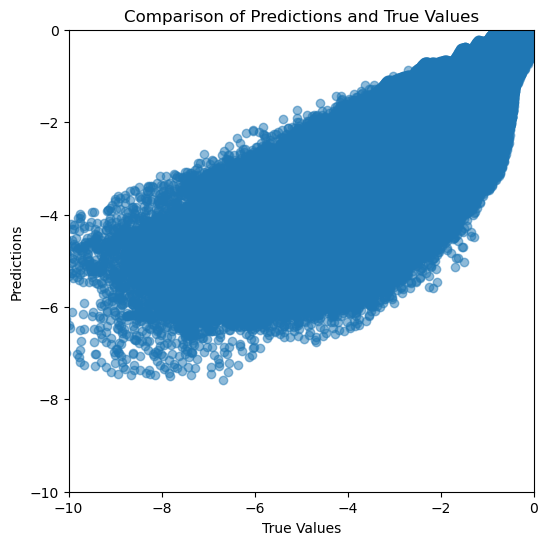

In [59]:
import matplotlib.pyplot as plt

# Assuming Y_test and predictions are 1D arrays for simplicity.
# Flatten arrays if they are not, e.g., predictions = predictions.flatten()
plt.figure(figsize=(6, 6))
plt.scatter(Y_test, predictions, alpha=0.5)
plt.title('Comparison of Predictions and True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Plot the perfect prediction line
#min_val = min(min(Y_test), min(predictions[:,1]))
#max_val = max(max(Y_test), max(predictions[:,1]))
#plt.plot([min_val, max_val], [min_val, max_val], 'r')
plt.xlim([-10,0])
plt.ylim([-10,0])

plt.show()
